In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, f1_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering


import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram



import pickle
import os

In [2]:
df = pd.read_csv("European_bank_marketing.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit,Ethnicity_African
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


In [3]:
df.shape

(41188, 22)

---
This dataset is highly imbalanced. Roughly 10% of the clients have a subscription to the term deposit. The number of non-subscribed clients is significantly higher than in the other. This can make it difficult for a model to predict the minority class accurately. We can adjust the trade-off between the tpr and fpr in the model's predictions by setting a probability threshold. We will set the thresholds and analyse the results further down the notebook.

---

No Subscription: 88.73 % of the dataset
Subscription: 11.27 % of the dataset


<AxesSubplot:>

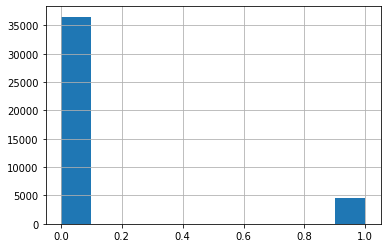

In [4]:
# The classes are heavily skewed. The probability threshold will solve the problem
print(f"No Subscription: {round(df['term_deposit'].value_counts()[0]/len(df) * 100,2)} % of the dataset")
print(f"Subscription: {round(df['term_deposit'].value_counts()[1]/len(df) * 100,2)} % of the dataset")
df['term_deposit'].hist()

In [5]:
##check for missing values
df.isnull().any().any()

False

In [6]:
target = ['term_deposit']
month = ['month']

vars_selected = [var for var in df.columns]

data_select = df[vars_selected]

print(f'We selected {len(vars_selected) - len(target)} variables for the pipeline')
print(f'We selected {len([var for var in vars_selected if var in target])} target variables for the pipeline')
print(data_select.shape)

We selected 21 variables for the pipeline
We selected 1 target variables for the pipeline
(41188, 22)


In [7]:
# make list of variables types
dates = ['month']
info = ['campaign']
# numerical: discrete and continuous
discrete = [var for var in data_select.columns if data_select[var].dtype != 'O' and var not in info and data_select[var].nunique() <= 10 and var not in dates and var not in target]

continuous = [var for var in data_select.columns if data_select[var].dtype != 'O' and var not in info and var not in discrete and var not in dates and var not in target]

# High cardinality
high = [var for var in data_select.columns if data_select[var].dtype=='O' and var not in info and data_select[var].nunique()>10 and var not in dates and var not in target]

#Few missing values 
few_miss = [ var for var in data_select.columns if data_select[var].isnull().sum() < 0.005 * data_select.shape[0] and data_select[var].isnull().sum() != 0 and var in continuous]

#Big missing values 
big_miss = [ var for var in data_select.columns if data_select[var].isnull().sum() >= 0.005 * data_select.shape[0] and data_select[var].isnull().sum() != 0 and var in continuous]

# categorical
categorical = [var for var in data_select.columns if data_select[var].dtype == 'O' and var not in info and var not in dates and var not in high ]
print(f'There are {len(discrete)} discrete variables')
print(f'There are {len(continuous)} continuous variables')
print(f'There are {len(high)} high cardinality variables')
print(f'There are {len(few_miss)} few miss ')
print(f'There are {len(big_miss)} big miss')
print(f'There are {len(categorical)} categorical variables')

There are 3 discrete variables
There are 7 continuous variables
There are 1 high cardinality variables
There are 0 few miss 
There are 0 big miss
There are 8 categorical variables


In [8]:
print(f'High = {high}\nDiscrete = {discrete}\nContinuous = {continuous}\nCategorical = {categorical}')

High = ['job']
Discrete = ['previous', 'emp.var.rate', 'Ethnicity_African']
Continuous = ['age', 'duration', 'pdays', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome']


In [9]:
df['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [10]:
df[categorical]

,marital,education,default,housing,loan,contact,day_of_week,poutcome
0,married,basic.4y,no,no,no,telephone,mon,nonexistent
1,married,high.school,unknown,no,no,telephone,mon,nonexistent
2,married,high.school,no,yes,no,telephone,mon,nonexistent
3,married,basic.6y,no,no,no,telephone,mon,nonexistent
4,married,high.school,no,no,yes,telephone,mon,nonexistent
...,...,...,...,...,...,...,...,...
41183,married,professional.course,no,yes,no,cellular,fri,nonexistent
41184,married,professional.course,no,no,no,cellular,fri,nonexistent
41185,married,university.degree,no,yes,no,cellular,fri,nonexistent
41186,married,professional.course,no,no,no,cellular,fri,nonexistent


## Feature Engineering

---
**Note**

The 'duration' feature represents the duration of the term deposit outcome call in seconds. The project specification highlights that this attribute has a strong impact on the target variable (Term Deposit) because if the duration is 0 seconds, it means the customer did not subscribe to the term deposit.

Including this feature in our model could lead to an overly optimistic model that relies heavily on the 'duration' feature to predict the outcome. However, in a real-world scenario, marketers won't know the duration of the call before it happens. Therefore, using the 'duration' feature to make predictions may not be practical or meaningful. **We may drop this feature.**

`Alternatively, we can create a categorical feature from it, representing different bins or ranges of call durations. This will help in capturing the underlying pattern without relying on the actual duration values. We propose a quantile-based binning.`

---

In [11]:
df.shape

(41188, 22)

In [12]:
# Create a new categorical feature 
# Four categories representing the quartiles of the 'duration' feature.
duration_labels = ['Very Short', 'Short', 'Long', 'Very Long']
df['duration_category'] = pd.qcut(df['duration'], q=4, labels=duration_labels)
# Convert 'duration_category' to an object data type
df['duration_category'] = df['duration_category'].astype('object')
df['duration_category'].head()

0     Long
1    Short
2     Long
3    Short
4     Long
Name: duration_category, dtype: object

---

Given that `nr.employed` is given in a quarterly indicator, we will categorise them that represents different levels of the number of employees.

---

In [13]:
# Create a new categorical feature based on the unique values of 'nr.employed'
bins = sorted(df['nr.employed'].unique())
labels = [f'numEmp_Q{i+1}' for i in range(len(bins) - 1)]
df['nr_employed_category'] = pd.cut(df['nr.employed'], bins=bins, labels=labels, include_lowest=True, right=True)
df['nr_employed_category'].head()

0    numEmp_Q8
1    numEmp_Q8
2    numEmp_Q8
3    numEmp_Q8
4    numEmp_Q8
Name: nr_employed_category, dtype: category
Categories (10, object): ['numEmp_Q1' < 'numEmp_Q2' < 'numEmp_Q3' < 'numEmp_Q4' ... 'numEmp_Q7' < 'numEmp_Q8' < 'numEmp_Q9' < 'numEmp_Q10']

---

Transform `pdays` variable to a binary feature, with a value of '1' if the customer was contacted in the previous campaign 
(i.e., 'pdays' is not 999) and '0' otherwise.

---

<AxesSubplot:>

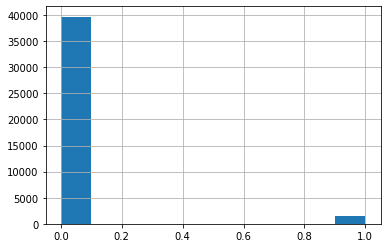

In [14]:
# Create a binary categorical feature for 'pdays'
df['contacted_prev_campaign'] = (df['pdays'] != 999).astype(int)
df['contacted_prev_campaign'].hist()

---

Categorise the `job` feature based on collar color

---

In [15]:
def categorise_occupation(occupation):
    if occupation in ['admin.', 'management', 'entrepreneur', 'technician']:
        return 'white_collar'
    elif occupation in ['housemaid', 'services', 'blue-collar', 'self-employed']:
        return 'blue_collar'
    elif occupation in ['unknown', 'unemployed']:
        return 'no_occupation'
    else:
        return 'other'

# Apply the categorisation function to the occupation column
df['occupation_group'] = df['job'].apply(categorise_occupation)
df['occupation_group'].unique()

array(['blue_collar', 'white_collar', 'other', 'no_occupation'],
      dtype=object)

In [16]:
dropped_features = ['duration', 'pdays', 'job', 'nr.employed']
df = df.drop(dropped_features, axis=1)

In [17]:
df.shape

(41188, 22)

In [18]:
new_discrete = [d for d in discrete if d not in dropped_features]
new_continuous = [c for c in continuous if c not in dropped_features]

In [19]:
def plot_boxplot_and_hist(data, variables):
    for variable in variables:
        # creating a figure composed of two matplotlib.Axes 
        # objects (ax_box and ax_hist)

        f, (ax_box, ax_hist) = plt.subplots(
            2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)}
        )

        # assigning a graph to each ax
        sns.boxplot(x=data[variable], ax=ax_box)
        sns.histplot(data=data, x=variable, ax=ax_hist)

        # Remove x axis name for the boxplot
        ax_box.set(xlabel="")
        plt.title(variable)
        plt.show()

    
def find_limits(df, variables, fold):
    limits = {}
    for variable in variables:
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

        lower_limit = df[variable].quantile(0.25) - (IQR * fold)
        upper_limit = df[variable].quantile(0.75) + (IQR * fold)

        limits[variable] = (lower_limit, upper_limit)

    return limits

def diagnostic_plots(df, variables):
    for variable in variables:

        # function to plot a histogram and a Q-Q plot
        # side by side, for a certain variable

        plt.figure(figsize=(15, 6))

        # histogram
        plt.subplot(1, 2, 1)
        df[variable].hist(bins=30)
        plt.title(f"Histogram of {variable}")

        # q-q plot
        plt.subplot(1, 2, 2)
        stats.probplot(df[variable], dist="norm", plot=plt)
        plt.title(f"Q-Q plot of {variable}")

        plt.show()
        
def remove_outliers(df, variables, limits):
    df_copy = df.copy()
    for var in variables:
        lower_limit, upper_limit = limits[var]
        df_copy = df_copy[df_copy[var].ge(lower_limit) & df_copy[var].le(upper_limit)]
    return df_copy

def log_transform(df, variables):
    df_copy = df.copy()
    for col in variables:
        df_copy[col] = np.log1p(df_copy[col])
    return df_copy

def equal_freq_binning(df, variables, q=10):
    df_copy = df.copy()
    for col in variables:
        df_copy[col] = pd.qcut(df_copy[col], q=q, duplicates='drop', labels=False)
    return df_copy


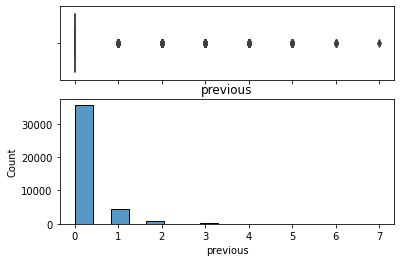

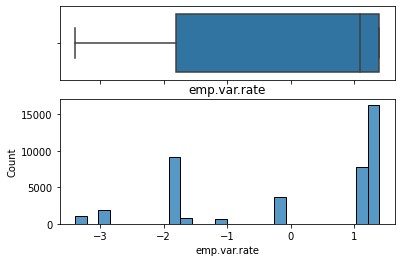

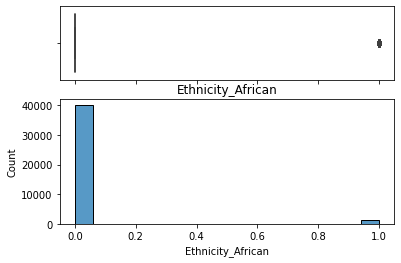

In [20]:
plot_boxplot_and_hist(df, new_discrete)

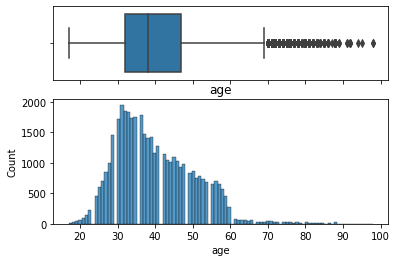

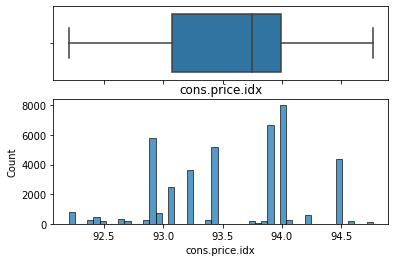

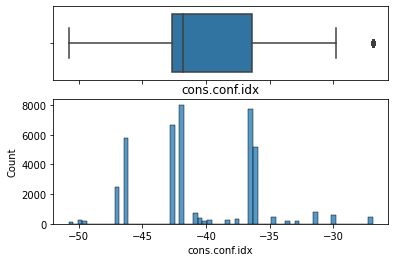

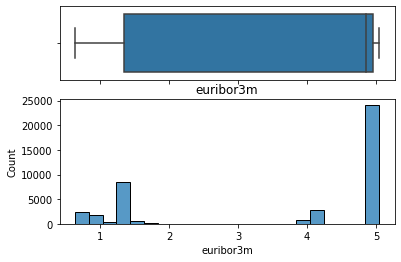

In [21]:
plot_boxplot_and_hist(df, new_continuous)

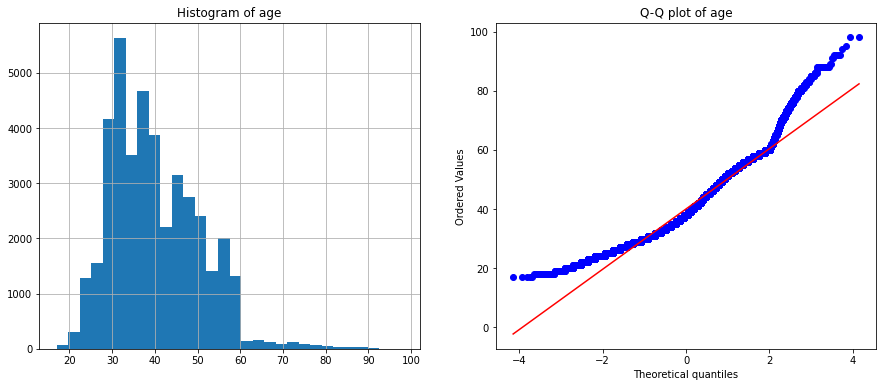

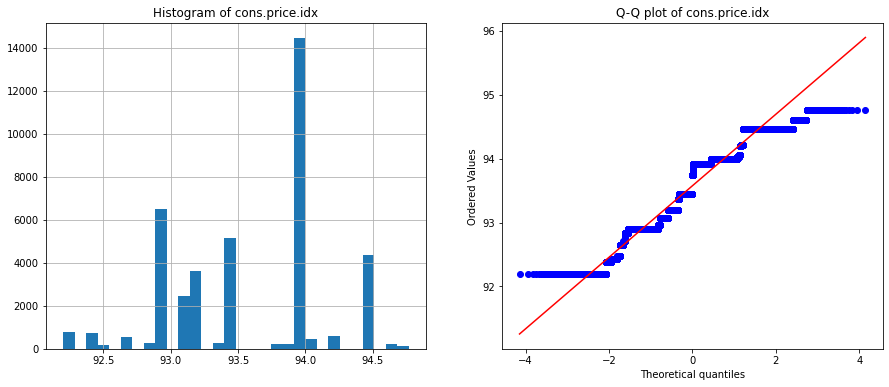

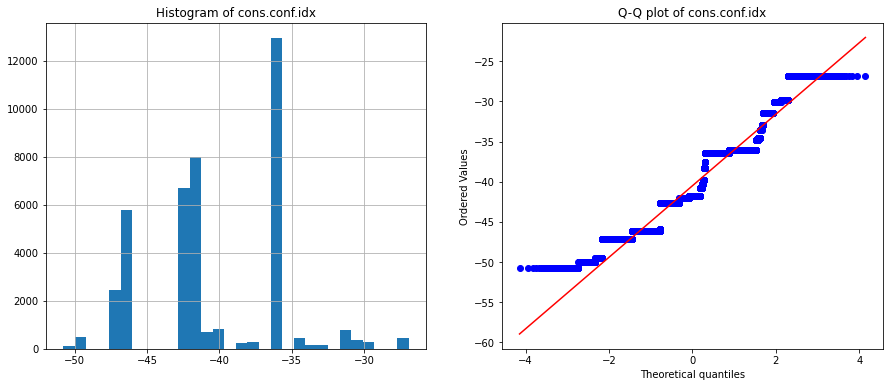

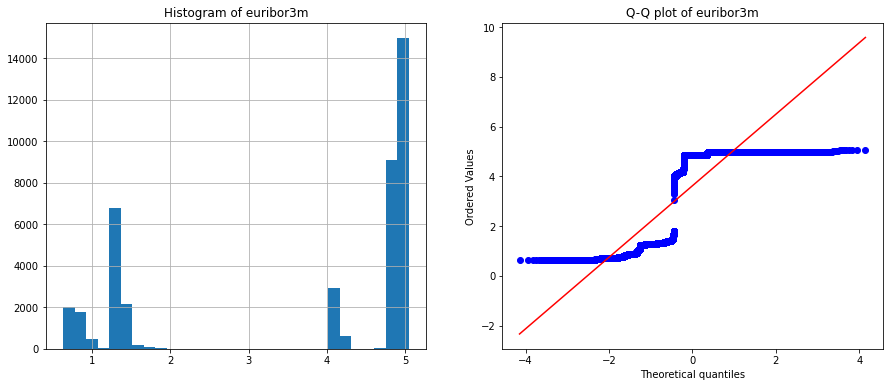

In [22]:
diagnostic_plots(df, new_continuous)

In [23]:
discrete_without_previous = [var for var in new_discrete if var != 'previous' and var != 'Ethnicity_African']
limits = find_limits(df, new_discrete, 1)
# Define the pipeline
pipeline = Pipeline([
    ('remove_outliers', FunctionTransformer(remove_outliers, kw_args={'variables': discrete_without_previous, 'limits': limits})),
    ('log_transform', FunctionTransformer(log_transform, kw_args={'variables': ['previous', 'campaign']})),
    ('equal_freq_binning', FunctionTransformer(equal_freq_binning, kw_args={'variables': new_continuous})),
])

# Apply the pipeline to the data
df_transformed = pipeline.fit_transform(df)

In [24]:
df_transformed.shape

(41188, 22)

In [25]:
print(f'High = {high}\nDiscrete = {discrete}\nContinuous = {continuous}\nCategorical = {categorical}')

High = ['job']
Discrete = ['previous', 'emp.var.rate', 'Ethnicity_African']
Continuous = ['age', 'duration', 'pdays', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome']


<AxesSubplot:>

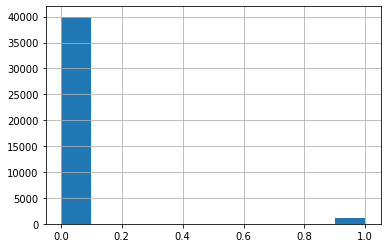

In [26]:
df['Ethnicity_African'].hist()

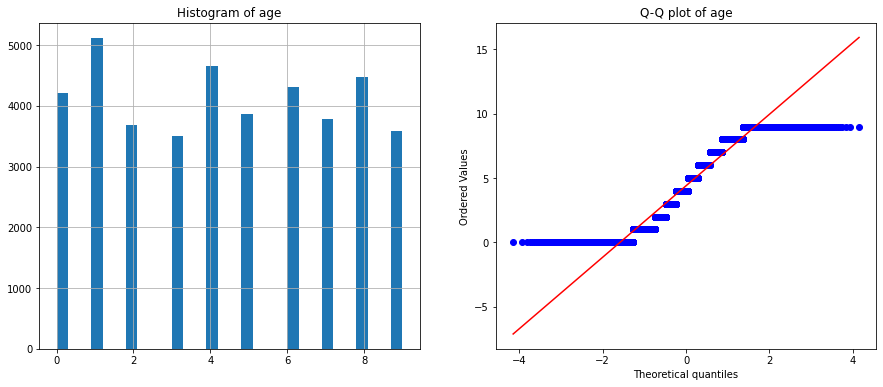

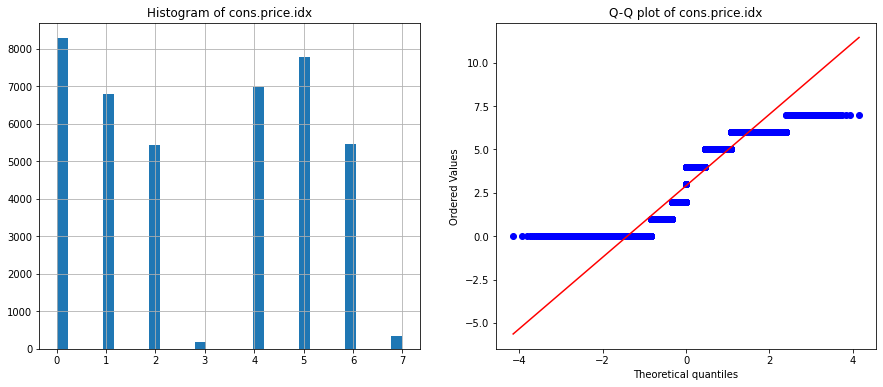

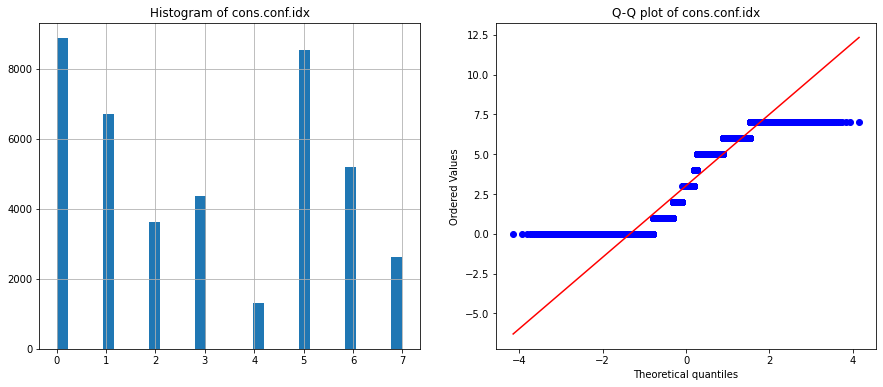

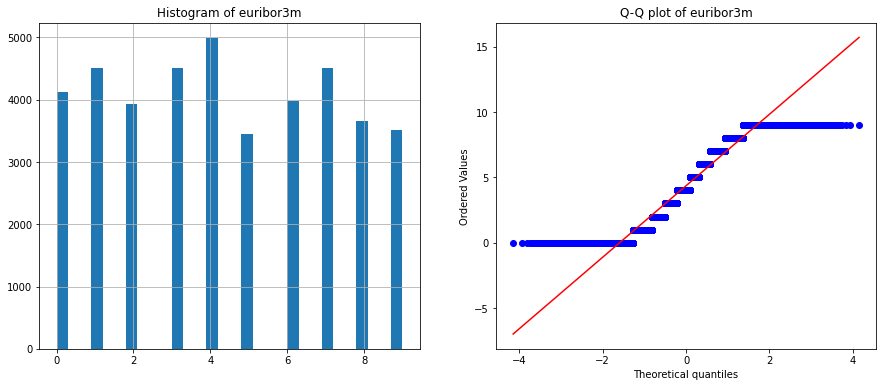

In [27]:
diagnostic_plots(df_transformed, new_continuous)

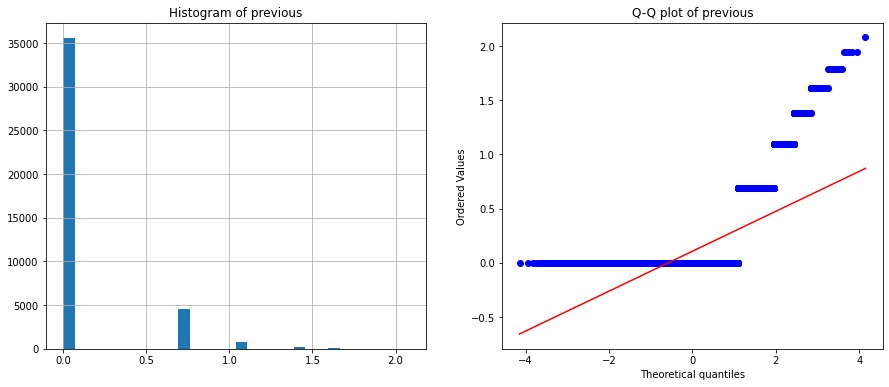

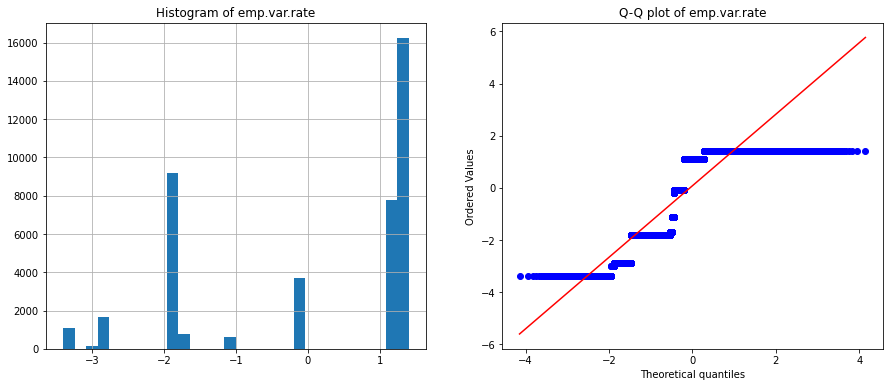

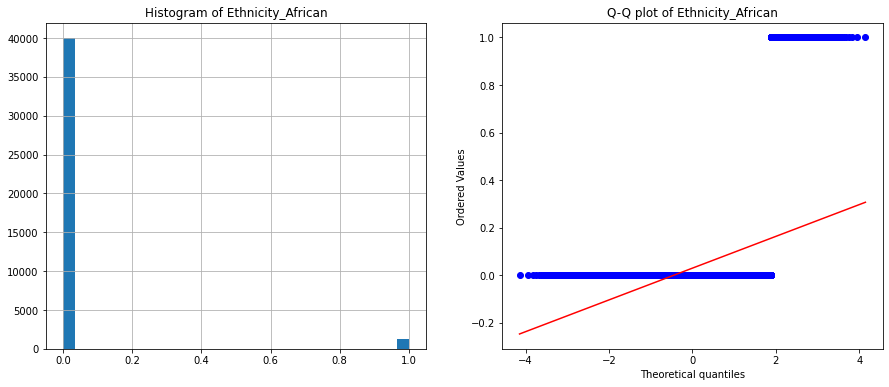

In [28]:
diagnostic_plots(df_transformed, new_discrete)

In [29]:
skew(df_transformed['campaign'])

1.350354093014719

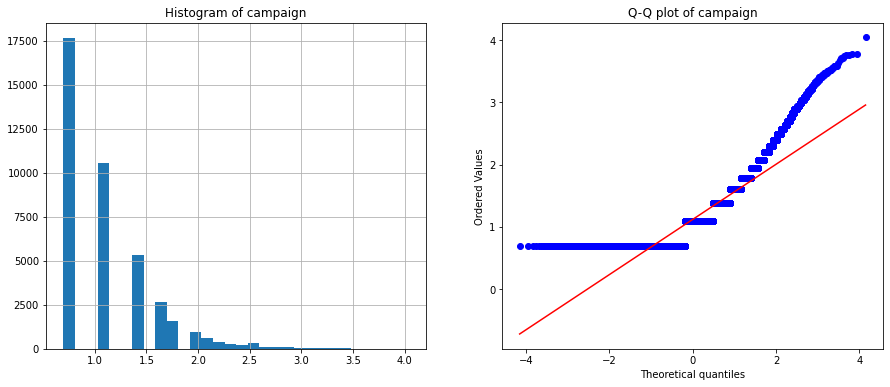

In [30]:
diagnostic_plots(df_transformed, ["campaign"])

In [31]:
skew(df_transformed['previous']), skew(df['previous'])

(2.586945975754835, 3.8319026847007014)

#### Data Transformation

- Convert categorical features to numerical using Ordinal/OneHot encoder

- Scale numerical features that have different ranges using StandardSclaer()


In [32]:
new_continuous

['age', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']

In [33]:
new_discrete

['previous', 'emp.var.rate', 'Ethnicity_African']

In [34]:
# numerical features
num_features = ['age', 'campaign', 'cons.price.idx', 'cons.conf.idx', 
                'euribor3m', 'previous', 'emp.var.rate']

# # Plot the distribution of the feature
# for i in num_features:
#     # Calculate skewness
#     transformed_feature = np.log1p(df_transformed[i])
#     original_skew = skew(df_transformed[i])
#     transformed_skew = skew(transformed_feature)
#     print(f"Skewness of original {i} feature: {original_skew:.2f}")
#     print(f"Skewness of log-transformed {i} feature: {transformed_skew:.2f}")
    
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.hist(df[i], bins=30)
#     plt.title(f"Distribution of {i}")
    

In [35]:
df_transformed[num_features].describe()

,age,campaign,cons.price.idx,cons.conf.idx,euribor3m,previous,emp.var.rate
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,4.401937,1.118991,2.910654,3.019375,4.359425,0.107943,0.081886
std,2.878497,0.491402,2.198853,2.384744,2.822098,0.283014,1.570960
min,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,-3.400000
25%,2.000000,0.693147,1.000000,1.000000,2.000000,0.000000,-1.800000
50%,4.000000,1.098612,3.000000,3.000000,4.000000,0.000000,1.100000
75%,7.000000,1.386294,5.000000,5.000000,7.000000,0.000000,1.400000
max,9.000000,4.043051,7.000000,7.000000,9.000000,2.079442,1.400000


<AxesSubplot:>

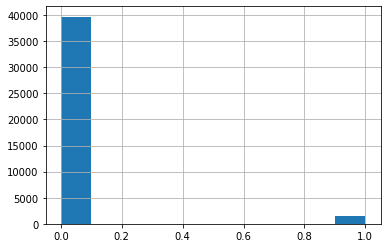

In [36]:
df_transformed['contacted_prev_campaign'].hist()

In [37]:
# Reset the index of the original dataframe
df_transformed.reset_index(drop=True, inplace=True)

# One-hot encode nominal categorical features
nominal_features = ['occupation_group', 'marital', 'contact', 'nr_employed_category', 'duration_category']
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(df_transformed[nominal_features])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(nominal_features))

# Ordinal encode ordinal categorical features (these features represent hierarchy)
ordinal_features = ['education', 'poutcome', 'month', 'day_of_week']
ordinal_categories = [list(df_transformed['education'].unique()), list(df_transformed['poutcome'].unique()), list(df_transformed['month'].unique()), 
                     list(df_transformed['day_of_week'].unique())]
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
ordinal_encoded = ordinal_encoder.fit_transform(df_transformed[ordinal_features])
ordinal_encoded_df = pd.DataFrame(ordinal_encoded, columns=ordinal_features)

# One-hot encode 'default', 'housing', and 'loan' features
additional_features = ['default', 'housing', 'loan']
#'drop' parameter to make a binary feature: one for 'yes' and one for 'unknown', with 'no' being the reference category.
#This helps to reduce multicollinearity
onehot_encoder_additional = OneHotEncoder(sparse=False, drop='first')
onehot_encoded_additional = onehot_encoder_additional.fit_transform(df_transformed[additional_features])
onehot_encoded_additional_df = pd.DataFrame(onehot_encoded_additional, 
                                            columns=onehot_encoder_additional.get_feature_names_out(additional_features))


df_processed = pd.concat([onehot_encoded_df, ordinal_encoded_df, onehot_encoded_additional_df, 
                          df_transformed[num_features], df_transformed[['Ethnicity_African','contacted_prev_campaign']]], axis=1)

# Scale numerical features
scaler = StandardScaler()
df_processed[num_features] = scaler.fit_transform(df_processed[num_features])

In [38]:
#check which features are not in df_processed
[x for x in df_transformed.columns if x not in nominal_features and x not in ordinal_features and 
 x not in additional_features and x not in num_features and x not in 'contacted_prev_campaign' and x not in 'Ethnicity_African']

['term_deposit']

---

## Q2 (a)

` Fit a logistic regression model on the dataset. Choose a probability threshold of 10 % , 20%, 35% and 50%, to assign an observation to the Term Deposit = 1 class. Compute a confusion matrix for each of the probability thresholds. How do the True Positive and False Positive rates vary over these probability thresholds? Which probability threshold would you
choose?`
---

In [ ]:
# Split the dataset into X (features) and y (target)
X = df_processed
y = df_transformed['term_deposit']
# Fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)
# Predict probabilities
y_proba = log_reg.predict_proba(X)

In [ ]:
def confusion_matrix_thresholds(y, y_proba_list, classifier_names, thresholds):
    for y_proba, classifier_name in zip(y_proba_list, classifier_names):
        print(f"\n---Classifier: {classifier_name}---\n")
        for threshold in thresholds:
            y_pred = (y_proba[:, 1] >= threshold).astype(int)
            cm = confusion_matrix(y, y_pred)

            # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
            TPR = cm[1, 1] / (cm[1, 1] + cm[1, 0])
            FPR = cm[0, 1] / (cm[0, 1] + cm[0, 0])
            
            f1 = f1_score(y, y_pred)
            

            print(f"Threshold: {threshold}")
            print("Confusion Matrix:\n\n")
            ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
            ax.set_xticklabels(['Not Subscribed (0)', 'Subscribed (1)'])
            ax.set_yticklabels(['Not Subscribed (0)', 'Subscribed (1)'])
            plt.xlabel('Actual Class', labelpad=15)
            plt.ylabel('Predicted Class')
            plt.title(f'{classifier_name}: {threshold * 100:.0f}%\n\n')
            plt.show()
            print(f"\n\nTrue Positive Rate: {TPR:.2f}")
            print(f"False Positive Rate: {FPR:.2f}")
            print(f"F1-Score: {f1:.2f}\n")
        
# Define the probability thresholds
thresholds = [0.1, 0.2, 0.35, 0.5]
confusion_matrix_thresholds(y=y, y_proba_list=[y_proba], classifier_names=["Logistic Regression"], thresholds=thresholds)

---
## Analysis

The True Positive Rate (TPR) and False Positive Rate (FPR) vary over the probability thresholds as follows:

- At a threshold of 0.1, TPR is high (0.68) while FPR is relatively high as well (0.20).
- At a threshold of 0.2, TPR decreases to 0.54, but FPR also decreases to 0.09.
- At a threshold of 0.35, TPR further decreases to 0.35, and FPR continues to decrease to 0.03.
- At a threshold of 0.5, TPR reaches its lowest value at 0.23, while FPR is at its lowest value of 0.01.

As the probability threshold increases, both the TPR and FPR decreases. This means that as you raise the threshold, the classifier becomes more conservative, and the number of false positives decreases, but at the expense of also identifying fewer true positives.

A threshold of 0.2 may be a sensible option because it provides a TPR of 0.54 and an FPR of 0.9, which is a reasonable trade-off between capturing potential subscribers and minimizing false positives. In addition, the F1-Score is the highest across all thresholds

---

## Q2(b)

` Divide the dataset into training (70%) and test (30%) sets and repeat the above question and
report the performance of these models, across probability thresholds, on the test set.`

In [ ]:
# Split the dataset into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model on the training set
log_reg_split = LogisticRegression(max_iter=500)
log_reg_split.fit(X_train, y_train)

# Predict probabilities on the test set
y_proba_test = log_reg_split.predict_proba(X_test)

# Define the probability thresholds
thresholds = [0.1, 0.2, 0.35, 0.5]
confusion_matrix_thresholds(y=y_test, y_proba_list=[y_proba_test], classifier_names=["Logistic Regression"], 
                            thresholds=thresholds)

---

## Analysis

The True Positive Rate (TPR) and False Positive Rate (FPR) vary over the probability thresholds as follows:

- At a threshold of 0.1, TPR is high (0.70) while FPR is relatively high as well (0.21).
- At a threshold of 0.2, TPR decreases to 0.54, but FPR also decreases to 0.09.
- At a threshold of 0.35, TPR further decreases to 0.34, and FPR continues to decrease to 0.03.
- At a threshold of 0.5, TPR reaches its lowest value at 0.21, while FPR is at its lowest value of 0.01.

The True Positive Rate falls as the probability threshold rises, making the model more cautious in identifying an observation as positive. However, the False Positive Rate also falls, which means the model is better at categorizing negative cases.

Once again, a threshold of 0.2 may be a sensible option because it provides a TPR of 0.54 and an FPR of 0.9, which is a reasonable trade-off between capturing potential subscribers and minimizing false positives. It also has the highest F1-Score of 0.48.

---

## Q2 (c) 

` Plot the ROC for a logistic model on a graph and compute the AUC. Explain the information
conveyed by the ROC and the AUC metrics.`

In [ ]:
def graph_roc_curve_for_thresholds(classifiers, classifier_names, colours, thresholds):
    threshold_colours = colours[:len(thresholds)]  # Create a separate list for threshold colours
    
    if len(classifiers) == 1:
        # If only one classifier is provided, plot ROC curves for all thresholds in a single graph
        plt.figure(figsize=(8, 6))
        plt.title(f'ROC Curve for {classifier_names[0]} at Different Thresholds', fontsize=18)
        clf = classifiers[0]
        clf_name = classifier_names[0]
        color = colours[0]

        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
        
        for threshold, threshold_color in zip(thresholds, threshold_colours):
            y_pred = (y_proba[:, 1] >= threshold).astype(int)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            auc_score = roc_auc_score(y_test, y_pred) * 100
            plt.plot(fpr, tpr, label=f'Threshold: {threshold * 100:.0f}% (Score = {auc_score:.2f}%)', color=threshold_color)

    else:
        # If multiple classifiers are provided, create a separate graph for each threshold
        for threshold in thresholds:
            plt.figure(figsize=(8, 6))
            plt.title(f'ROC Curve at {threshold * 100:.0f}% Threshold \n Classifiers', fontsize=18)
            
            for clf, clf_name, color in zip(classifiers, classifier_names, colours):
                clf.fit(X_train, y_train)
                y_proba = clf.predict_proba(X_test)
                y_pred = (y_proba[:, 1] >= threshold).astype(int)
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                auc_score = roc_auc_score(y_test, y_pred) * 100
                plt.plot(fpr, tpr, label=f'{clf_name} (Score = {auc_score:.2f}%)', color=color)

                plt.legend()
                
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n ("No information classifier")', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                 )
    plt.legend()
    plt.show()
    
    
def graph_roc_curve_multiple(classifiers, classifier_names, colours):
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve \n Classifiers', fontsize=18)
    
    for clf, clf_name, color in zip(classifiers, classifier_names, colours):
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1], drop_intermediate=False)
        auc_score = roc_auc_score(y_test, y_proba[:, 1]) * 100
        plt.plot(fpr, tpr, label=f'{clf_name} (Score = {auc_score:.2f}%)', color=color)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n ("No information classifier")', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                 )
    plt.legend()
    plt.show()



    
def plot_feature_importance(models, model_names, X):
    n_features = X.shape[1]
    feature_names = X.columns

    for model, model_name in zip(models, model_names):
        if model_name == 'Logistic Regression':
            # For logistic regression, we'll use the absolute value of coefficients for feature importance
            importance = np.abs(model.coef_[0])
        elif model_name in ['Decision Trees', 'Random Forest']:
            importance = model.feature_importances_
        else:
            print(f"Feature importance not available for {model_name}. Skipping.")
            continue

        sorted_idx = np.argsort(importance)[-10:]

        plt.figure(figsize=(10, 5))
        plt.barh(range(10), importance[sorted_idx], align='center')
        plt.yticks(np.arange(10), feature_names[sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 10 Feature Importance - {model_name}')
        plt.show()

In [ ]:
classifier = [log_reg_split]
classifier_name = ["Logistic Regression"]
colour = ['navy', 'orange', 'red', 'green']
graph_roc_curve_for_thresholds(classifiers=classifier, classifier_names=classifier_name, colours=colour, thresholds=thresholds)
#graph_roc_curve_multiple(classifier, classifier_name, colours=colour)

## Q3 (a)

`Fit three alternative machine learning models (e.g., classification tree, bagging, random forest models; KNN or SVM algorithms) in the data and comment on the performance of these models. Which model would you choose and why?`

In [ ]:
def fit_models(X_train, y_train):
    dtc = DecisionTreeClassifier().fit(X_train, y_train)
    knn = KNeighborsClassifier().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    bagc = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=1).fit(X_train, y_train)
    return dtc, knn, rfc, bagc

# Predict probabilities
def predict_probabilities(models, X_test):
    proba_list = []
    for model in models:
        proba_list.append(model.predict_proba(X_test))
    return proba_list

def optimize_hyperparameters(X, y):
    # Create a list of classifiers with their hyperparameter grids
    classifiers = [
        {
            'name': 'Logistic Regression',
            'estimator': LogisticRegression(),
            'params': {
                'C': np.logspace(-4, 4, 10),
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }
        },
        {
            'name': 'Decision Trees',
            'estimator': DecisionTreeClassifier(),
            'params': {
                'max_depth': [3, 5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        {
            'name': 'Random Forest',
            'estimator': RandomForestClassifier(),
            'params': {
                'n_estimators': [10, 50, 100],
                'max_depth': [3, 5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        {
            'name': 'BaggingClassifier (Decision Trees)',
            'estimator': BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=1),
            'params': {
                'base_estimator__max_depth': [3, 5, 10, 15, None],
                'base_estimator__min_samples_split': [2, 5],
                'base_estimator__min_samples_leaf': [1, 2],
                'n_estimators': [10, 50]
            }
        }
    ]

    best_models = []

    # Iterate through the classifiers list and perform hyperparameter optimization
    for classifier in classifiers:
        print(f"Optimizing {classifier['name']}...")

        best_score = -np.inf
        best_params = None
        best_estimator = None

         #CHANGE TO GRIDSEARCHCV (ALSO CV=RANGE(5,11))
        random_search = RandomizedSearchCV(classifier['estimator'], classifier['params'], cv=5, 
                                   scoring='roc_auc', n_jobs=-1, random_state=42)
        random_search.fit(X, y)

        # Update best score, parameters, and estimator if a better score is found
        if random_search.best_score_ > best_score:
            best_score = random_search.best_score_
            best_params = random_search.best_params_
            best_estimator = random_search.best_estimator_

        best_models.append({
            'name': classifier['name'],
            'best_estimator': best_estimator,
            'best_params': best_params,
            'best_score': best_score,
        })

        print(f"Best parameters: {best_params}")
        print(f"Best roc_auc score: {best_score:.4f}\n")

    return best_models

**UNCOMMENT THE BELOW CODE BLOCK IF THE DATA HAS CHANGED**

In [ ]:
# best_models = optimize_hyperparameters(X_train, y_train)

# # Save the data as a binary file using pickle
# with open('best_models_3.pkl', 'wb') as f:
#     pickle.dump(best_models, f)

In [ ]:
# Load the data from the saved file
with open('best_models_3.pkl', 'rb') as f:
    best_models = pickle.load(f)
    
fitted_models = [model_info['best_estimator'] for model_info in best_models]

clf_pred_list = predict_probabilities(fitted_models, X_test)
classifier_names = [model_info['name'] for model_info in best_models]

thresholds = [0.1, 0.2, 0.35, 0.5]
confusion_matrix_thresholds(y=y_test, y_proba_list=clf_pred_list, 
                            classifier_names=classifier_names, thresholds=thresholds)

colour = ['navy', 'orange', 'red', 'green']
graph_roc_curve_for_thresholds(fitted_models, classifier_names, colour, thresholds)

In [ ]:
plot_feature_importance(fitted_models, classifier_names, X_train)

In [ ]:
def bagging_imp(best_models):
    # Extract the BaggingClassifier contents
    for model_dict in best_models:
        if model_dict["name"] == "BaggingClassifier (Decision Trees)":
            bagging_dict = {
                "best_estimator": model_dict["best_estimator"],
                "best_params": model_dict["best_params"],
                "best_score": model_dict["best_score"]
            }
            break

    # Compute the BaggingClassifier feature importances
    feature_importances = np.mean([
        tree.feature_importances_ for tree in bagging_dict['best_estimator'].estimators_
    ], axis=0)

    column_names = X_train.columns

    # Sort the indices by importance and select the top 10
    sorted_indices = feature_importances.argsort()[-10:]
    importance = feature_importances[sorted_indices]
    sorted_column_names = column_names[sorted_indices]

    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = range(10)
    ax.barh(y_pos, importance, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_column_names)
    ax.set_xlabel('Feature Importance')
    ax.set_title('Top 10 Feature Importance - BaggingClassifier')
    plt.show()
    
bagging_imp(best_models=best_models)

### Q4

` Evaluate the potential, from theoretical and empirical perspectives, of the following unsupervised learning techniques to improve (or not) the predictive modeling work you have reported.`

Techniques:

1. Principal Components Analysis
2. K-Means Clustering
3. Hierarchical Clustering

---

### PCA

---

In [ ]:
# Apply PCA
pca = PCA(n_components=16)
pca.fit(X_train)
# pca.fit(X_train)
# explained_variance_ratio = pca.explained_variance_ratio_
# n_components = np.arange(1, len(explained_variance_ratio) + 1)
# cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# plt.plot(n_components, cumulative_explained_variance)
# plt.xlabel("Number of Components")
# plt.ylabel("Cumulative Explained Variance")
# plt.title("Explained Variance vs Number of Components")
# plt.grid()
# plt.show()
# n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
# print(f"Number of components to retain 95% explained variance: {n_components_95}")


# Apply PCA to the training and testing sets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# # Optimize hyperparameters using the PCA-transformed data
# best_models_pca = optimize_hyperparameters(X_train_pca, y_train)

# # Save the data as a binary file using pickle
# with open('best_models_pca.pkl', 'wb') as f:
#     pickle.dump(best_models_pca, f)
                                       
# Load the data from the saved file
with open('best_models_pca.pkl', 'rb') as f:
    best_models_pca = pickle.load(f)
    
fitted_models_pca = [model_info['best_estimator'] for model_info in best_models_pca]

clf_pred_list_pca = predict_probabilities(fitted_models_pca, X_test_pca)
classifier_names_pca = [model_info['name'] for model_info in best_models_pca]

thresholds = [0.1, 0.2, 0.35, 0.5]

colour = ['navy', 'orange', 'red', 'green']
graph_roc_curve_for_thresholds(fitted_models_pca, classifier_names_pca, colour, thresholds)

In [ ]:
def plot_elbow(X, max_clusters):
    inertia = []
    for n_clusters in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters+1), inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('K-Means Elbow Method')
    plt.show()

# Determine the optimal number of clusters for K-Means
plot_elbow(X_train, max_clusters=10)

In [ ]:
# Create a K-Means clustering model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the K-Means model to the training data
kmeans.fit(X_train)

# Assign clusters to the data
X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

Optimize hyperparameters using the K-Means transformed data
# best_models_kmeans = optimize_hyperparameters(X_train_kmeans, y_train)

# # Save the data as a binary file using pickle
# with open('best_models_kmeans.pkl', 'wb') as f:
#     pickle.dump(best_models_kmeans, f)

# Load the data from the saved file
with open('best_models_kmeans.pkl', 'rb') as f:
    best_models_kmeans = pickle.load(f)

fitted_models_kmeans = [model_info['best_estimator'] for model_info in best_models_kmeans]

clf_pred_list_kmeans = predict_probabilities(fitted_models_kmeans, X_test_kmeans)
classifier_names_kmeans = [model_info['name'] for model_info in best_models_kmeans]


graph_roc_curve_for_thresholds(fitted_models_kmeans, classifier_names_kmeans, colour, thresholds)


In [ ]:
# # Create a hierarchical clustering model
# agg_clustering = AgglomerativeClustering(n_clusters=2)

# # Fit the hierarchical clustering model to the training data
# agg_clustering.fit(X_train)

# # Assign clusters to the data
# X_train_agg = pairwise_distances(X_train, metric='euclidean')
# X_test_agg = pairwise_distances(X_test, metric='euclidean')

# # Optimize hyperparameters using the hierarchical clustering transformed data
# best_models_agg = optimize_hyperparameters(X_train_agg, y_train)

# # Save the data as a binary file using pickle
# with open('best_models_agg.pkl', 'wb') as f:
#     pickle.dump(best_models_agg, f)

# # Load the data from the saved file
# with open('best_models_agg.pkl', 'rb') as f:
#     best_models_agg = pickle.load(f)

# fitted_models_agg = [model_info['best_estimator'] for model_info in best_models_agg]

# clf_pred_list_agg = predict_probabilities(fitted_models_agg, X_test_agg)
# classifier_names_agg = [model_info['name'] for model_info in best_models_agg]

# confusion_matrix_thresholds(y=y_test, y_proba_list=clf_pred_list_agg, classifier_names=classifier_names_agg, 
#                             thresholds=thresholds)

# graph_roc_curve_for_thresholds(fitted_models_agg, classifier_names_agg, colour, thresholds)
